<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S6_ASSIGNMENT/BN_L1LOSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)),
                                       transforms.RandomRotation((-7.0,7.0),fill=(0))
                                       #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])

In [3]:
train = datasets.MNIST('./data', train=True,  download=True, transform=train_transforms)
test =  datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA Available? True


**Visualize the input data with image standardization**


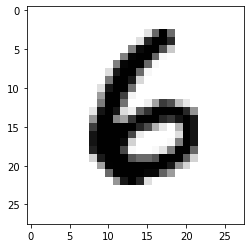

In [5]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

#print(images[0])
#print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

**Visualize the input data without image standardization**



In [6]:
#Comment this block from CODE2 onwards
#train_nonorm_transforms = transforms.Compose([
#                                       transforms.ToTensor()
#                                       #transforms.Normalize((0.1307,), (0.3081,))
#                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
#                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
#                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
#                                       ])
#test_nonorm_transforms  = transforms.Compose([
#                                       transforms.ToTensor()
#                                       #transforms.Normalize((0.1307,), (0.3081,))
#                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
#                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
#                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
#                                      ])
#train_nonorm = datasets.MNIST('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
#test_nonorm =  datasets.MNIST('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
#train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
#test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)
#dataiter_nonorm = iter(train_loader_nonorm)
#images, labels = dataiter_nonorm.next()
#print(images[0])
#print(labels.shape)
#
#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [7]:
dropout_perc = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_perc)
        ) # output_size = 26 ; #Receptive field = 3x3

        #CT1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_perc)
        ) # output_size = 24; #Receptive field = 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24; #Receptive field = 5x5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; #Receptive field = 6x6

        #CT2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_perc)
        ) # output_size = 10 ;  #Receptive field = 10x10

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),            
            nn.Dropout(dropout_perc)
        ) # output_size = 8 ; #Receptive field = 14x14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8 ; #Receptive field = 14x14
     
        #CT3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_perc)          
        ) # output_size = 6 ; #Receptive field = 18x18
                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 18, 24, 24]           1,620
              ReLU-6           [-1, 18, 24, 24]               0
       BatchNorm2d-7           [-1, 18, 24, 24]              36
           Dropout-8           [-1, 18, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             180
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.13317467272281647 Batch_id=468 Accuracy=87.63: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0806, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.03131955489516258 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:36<00:00, 12.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 9788/10000 (97.88%)

EPOCH: 2


Loss=0.043039992451667786 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:36<00:00, 12.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.04566382244229317 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


Loss=0.09389691799879074 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.09974818676710129 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.014370252378284931 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.01764441654086113 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.08718647807836533 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.012823033146560192 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.06356414407491684 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:36<00:00, 12.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.017373524606227875 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.012348306365311146 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.017870107665657997 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.0374867282807827 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:36<00:00, 12.78it/s]



Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)



In [11]:
import math as m
m.exp(10) + m.exp(8) + m.exp(3)

25027.509318771634

In [12]:
m.exp(10)/25027.509318771634


0.8800902045129192

In [13]:
m.exp(8) / 25027.509318771634

0.1191072571015243

In [14]:
m.exp(3) / 25027.509318771634

0.0008025383855565168

In [15]:
-1 * m.log(0.1191072571015243)

2.1277308716348595